In [33]:
from __future__ import annotations
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
from qtpyt.basis import Basis
from qtpyt.projector import expand
from qtpyt.base.selfenergy import DataSelfEnergy as BaseDataSelfEnergy

from gpaw import restart
from gpaw.lcao.pwf2 import LCAOwrap
from qtpyt.lo.tools import rotate_matrix, subdiagonalize_atoms, lowdin_rotation

In [34]:
from matplotlib.colors import LinearSegmentedColormap


maroon_cmap = LinearSegmentedColormap.from_list(
    "white_to_maroon",
    ["white", "#800000"],
    N=256
)

### Initialization

In [21]:
pl_path = Path("./dft/leads/")
cc_path = Path("./dft/device/")

data_folder = "./output/lowdin"
index_active_region = np.load(f"{data_folder}/index_active_region.npy")
self_energy = np.load(f"{data_folder}/self_energy.npy", allow_pickle=True)

H_leads_lcao, S_leads_lcao = np.load(pl_path / "hs_pl_k.npy")

basis_dict = {"Au": 9, "H": 5, "C": 13, "N": 13}

leads_atom = read(pl_path / "leads.xyz")
leads_basis = Basis.from_dictionary(leads_atom, basis_dict)

device_atoms = read(cc_path / "scatt.xyz")
device_basis = Basis.from_dictionary(device_atoms, basis_dict)

Nr = (1, 5, 3)
unit_cell_rep_in_leads = (5, 5, 3)

### Hamiltonian transformation from Lowdin LO to AO basis
 

In [22]:
def get_species_indices(atoms, species):
    indices = []
    for element in species:
        element_indices = atoms.symbols.search(element)
        indices.extend(element_indices)
    return sorted(indices)

lowdin = True

GPWDEVICEDIR = "./dft/device/"
GPWLEADSDIR = "./dft/leads/"
SUBDIAG_SPECIES = ("C", "N", "H")
active = {"C": [3], "N": [3]}

cc_path = Path(GPWDEVICEDIR)
pl_path = Path(GPWLEADSDIR)
gpwfile = f"{cc_path}/scatt.gpw"

atoms, calc = restart(gpwfile, txt=None)
fermi = calc.get_fermi_level()
nao_a = np.array([setup.nao for setup in calc.wfs.setups])
basis = Basis(atoms, nao_a)

lcao = LCAOwrap(calc)
H_lcao = lcao.get_hamiltonian()
S_lcao = lcao.get_overlap()
H_lcao -= fermi * S_lcao

subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)

Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)
H_subdiagonalized = rotate_matrix(H_lcao, Usub)
S_subdiagonalized = rotate_matrix(S_lcao, Usub)

if lowdin:
    Ulow = lowdin_rotation(H_subdiagonalized, S_subdiagonalized, index_active_region)

    H_subdiagonalized = rotate_matrix(H_subdiagonalized, Ulow)
    S_subdiagonalized = rotate_matrix(S_subdiagonalized, Ulow)

    H_subdiagonalized = H_subdiagonalized[None, ...]
    S_subdiagonalized = S_subdiagonalized[None, ...]


else:
    H_subdiagonalized = H_subdiagonalized[None, ...]
    S_subdiagonalized = S_subdiagonalized[None, ...]


Condition number: 1.0e+04


In [23]:
def dagger(A):
    return A.conj().T

def get_inverse(U: np.ndarray) -> np.ndarray:

    U_inv = np.linalg.inv(U)
    return U_inv

class DataSelfEnergy(BaseDataSelfEnergy):
    def retarded(self, energy):
        return expand(S_device, super().retarded(energy), index_active_region)


def load(filename):
    return DataSelfEnergy(energies, np.load(filename))

def compose_forward_and_reverse(
    Usub: np.ndarray,
    Usub_inv: np.ndarray,
    Ulow: np.ndarray,
    Ulow_inv: np.ndarray,
) -> tuple[np.ndarray, np.ndarray]:
    r"""Compose total forward and reverse transforms.

    Returns
    -------
    Utot, Urev
        Forward Utot = Usub Ulow (LCAO -> Lowdin-LO),
        Reverse Urev = Utot^{-1}  (Lowdin-LO -> LCAO).

    Notes
    -----
    We compute Urev as:

    .. math::
        Urev = Ulow^{-1} Usub^{-1}

    using explicit solves rather than assuming unitarity.
    """
    Utot = Usub @ Ulow

    Urev = Ulow_inv @ Usub_inv
    return Utot, Urev


def check_inverse_pair(
    U: np.ndarray,
    Uinv: np.ndarray,
    *,
    name: str,
    atol: float = 1e-8,
) -> None:
    r"""Check that Uinv is the inverse of U on both sides.

    Notes
    -----
    We check both:
    .. math::
        \|Uinv\,U - I\| \quad \text{and} \quad \|U\,Uinv - I\|
    because for non-unitary matrices numerical errors can be asymmetric.
    """
    n = U.shape[0]
    I = np.eye(n, dtype=U.dtype)

    left = np.linalg.norm(Uinv @ U - I) / np.linalg.norm(I)
    right = np.linalg.norm(U @ Uinv - I) / np.linalg.norm(I)
    if left >= atol or right >= atol:
        raise AssertionError(
            f"{name}: inverse check failed. "
            f"relerr_left=||Uinv U - I||={left:g}, "
            f"relerr_right=||U Uinv - I||={right:g}"
        )
    else:
        print(
            f"{name}: inverse check passed. "
            f"relerr_left=||Uinv U - I||={left:g}, "
            f"relerr_right=||U Uinv - I||={right:g}"
        )

def sanity_checks(
    Usub: np.ndarray,
    Usub_inv: np.ndarray,
    Ulow: np.ndarray,
    Ulow_inv: np.ndarray,
    Urev: np.ndarray,
    S_lcao: np.ndarray,
    index_active_region: np.ndarray,
    atol: float = 1e-8,
) -> None:
    r"""Run basic numerical checks and raise AssertionError if something is off.

    Checks performed
    ----------------
    1) Usub inverse consistency
       .. math:: Usub^{-1} Usub \approx I,\;\; Usub Usub^{-1} \approx I
    2) Ulow inverse consistency (full-space embedded matrix)
       .. math:: Ulow^{-1} Ulow \approx I,\;\; Ulow Ulow^{-1} \approx I
    3) Total inverse consistency
       .. math:: Urev (Usub Ulow) \approx I
    4) Active-space overlap becomes identity after Lowdin
       .. math:: (Ulow^\dagger Usub^\dagger) S (Usub Ulow) \approx I \text{ on active block}
    """
    n = S_lcao.shape[0]
    I = np.eye(n, dtype=S_lcao.dtype)

    check_inverse_pair(Usub, Usub_inv, name="Usub", atol=atol)

    check_inverse_pair(Ulow, Ulow_inv, name="Ulow", atol=atol)

    Utot = Usub @ Ulow
    err_tot = np.linalg.norm(Urev @ Utot - I) / np.linalg.norm(I)
    if err_tot >= atol:
        raise AssertionError(f"Urev*Utot not identity: relerr={err_tot:g}")
    else:
        print(f"Urev*Utot identity check passed: relerr={err_tot:g}")

    err_tot_r = np.linalg.norm(Utot @ Urev - I) / np.linalg.norm(I)
    if err_tot_r >= atol:
        raise AssertionError(f"Utot*Urev not identity: relerr={err_tot_r:g}")
    else:
        print(f"Utot*Urev identity check passed: relerr={err_tot_r:g}")

    S_lo = rotate_matrix(S_lcao, Usub)
    S_low = rotate_matrix(S_lo, Ulow)
    idx = np.asarray(index_active_region, dtype=int)
    S_active = S_low[np.ix_(idx, idx)]
    err2 = np.linalg.norm(S_active - np.eye(len(idx), dtype=S_active.dtype))
    if err2 >= 50 * atol:
        raise AssertionError(f"Active overlap not identity after Lowdin: ||Δ||={err2:g}")
    else:
        print(f"Active overlap identity check passed after Lowdin: ||Δ||={err2:g}")

In [24]:
Usub_inv = get_inverse(Usub)
Ulow_inv = get_inverse(Ulow)

Utot, Urev = compose_forward_and_reverse(Usub, Usub_inv, Ulow, Ulow_inv)

sanity_checks(Usub, Usub_inv, Ulow, Ulow_inv, Urev, S_lcao, index_active_region)

Usub: inverse check passed. relerr_left=||Uinv U - I||=1.0757e-16, relerr_right=||U Uinv - I||=5.67974e-17
Ulow: inverse check passed. relerr_left=||Uinv U - I||=9.70902e-18, relerr_right=||U Uinv - I||=8.58548e-18
Urev*Utot identity check passed: relerr=1.08696e-16
Utot*Urev identity check passed: relerr=6.35717e-17
Active overlap identity check passed after Lowdin: ||Δ||=3.83632e-15


In [25]:
def compute_relative_frobenius_error(A: np.ndarray, B: np.ndarray) -> float:
    r"""Relative Frobenius error: ||A-B||_F / ||A||_F."""
    num = np.linalg.norm(A - B)
    den = np.linalg.norm(A)
    return float(num / den) if den != 0 else float(num)

def hermiticity_error(A: np.ndarray) -> float:
    r"""Absolute Frobenius norm of anti-Hermitian part: ||A - A^\dagger||_F."""
    return float(np.linalg.norm(A - dagger(A)))

def hamiltonian_roundtrip_checks(
    H_lcao: np.ndarray,
    Usub: np.ndarray,
    Usub_inv: np.ndarray,
    Ulow: np.ndarray,
    Ulow_inv: np.ndarray,
    *,
    atol_rel: float = 1e-10,
    atol_herm: float = 1e-10,
) -> None:
    r"""Verify that forward+reverse basis transforms recover the original Hamiltonian.

    Checks
    ------
    1) LCAO -> LO:
       .. math:: H_{lo} = U_{sub}^\dagger H_{lcao} U_{sub}
    2) LO -> Lowdin-LO:
       .. math:: H_{low} = U_{low}^\dagger H_{lo} U_{low}
    3) Reverse back:
       .. math::
           H_{lo}^{(rt)}   = (U_{low}^{-1})^\dagger H_{low} (U_{low}^{-1})
           H_{lcao}^{(rt)} = (U_{sub}^{-1})^\dagger H_{lo}^{(rt)} (U_{sub}^{-1})

    We then compare :math:`H_{lcao}^{(rt)}` to :math:`H_{lcao}`.

    Notes
    -----
    - Use relative Frobenius error for meaningful scale-invariant comparison.
    - Also check Hermiticity drift, since numerical transforms can introduce tiny
      anti-Hermitian parts if inputs are not perfectly Hermitian.
    """
    H_lo = rotate_matrix(H_lcao, Usub)
    H_low = rotate_matrix(H_lo, Ulow)

    H_lo_rt = rotate_matrix(H_low, Ulow_inv)
    H_lcao_rt = rotate_matrix(H_lo_rt, Usub_inv)

    err_rel = compute_relative_frobenius_error(H_lcao, H_lcao_rt)
    if err_rel >= atol_rel:
        raise AssertionError(
            f"H round-trip failed: rel Fro error ||H - H_rt||/||H|| = {err_rel:g}"
        )
    else:
        print(
            f"H round-trip check passed: rel Fro error ||H - H_rt||/||H|| = {err_rel:g}"
        )

    herm_in = hermiticity_error(H_lcao)
    herm_rt = hermiticity_error(H_lcao_rt)
    if herm_rt >= max(atol_herm, 10 * herm_in):
        raise AssertionError(
            f"H Hermiticity drift too large: ||H_rt - H_rt^†|| = {herm_rt:g} "
            f"(input anti-Herm norm was {herm_in:g})"
        )
    else:
        print(
            f"H Hermiticity drift check passed: ||H_rt - H_rt^†|| = {herm_rt:g} "
            f"(input anti-Herm norm was {herm_in:g})"
        )

In [26]:
hamiltonian_roundtrip_checks(
    H_lcao,
    Usub, Usub_inv,
    Ulow, Ulow_inv,
    atol_rel=1e-10,
    atol_herm=1e-10,
)
hamiltonian_roundtrip_checks(
    S_lcao,
    Usub, Usub_inv,
    Ulow, Ulow_inv,
    atol_rel=1e-10,
    atol_herm=1e-10,
)

H round-trip check passed: rel Fro error ||H - H_rt||/||H|| = 1.96184e-16
H Hermiticity drift check passed: ||H_rt - H_rt^†|| = 7.75323e-14 (input anti-Herm norm was 0)
H round-trip check passed: rel Fro error ||H - H_rt||/||H|| = 1.39164e-16
H Hermiticity drift check passed: ||H_rt - H_rt^†|| = 5.23479e-15 (input anti-Herm norm was 0)


### Self-energy Transformation from Lowdin LO to MO basis
The leads self-energies are already in the MO basis, so no transformation is needed here.

In [38]:
S_device = S_subdiagonalized[0].copy()
ed_self_energy_file = f"{data_folder}/ed/self_energy_with_dcc.npy"
energies = np.array([0.0])
ed_sigma = load(ed_self_energy_file)
es_lo = ed_sigma.retarded(0.0)
Urev_conj = Urev.conj().T
es_lcao = Urev_conj @ es_lo @ Urev

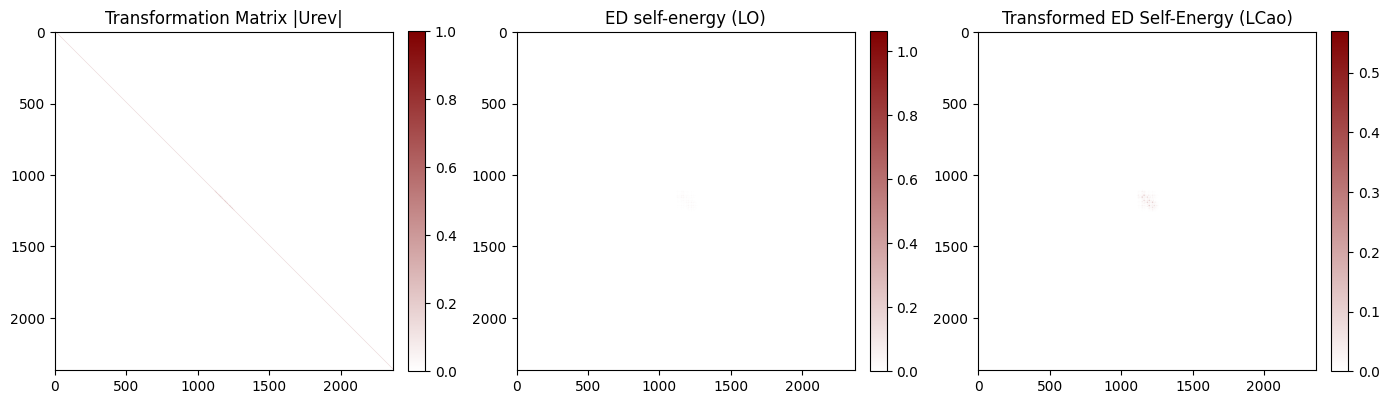

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(14, 8))

# --- Row 1 ---
im0 = axes[0].imshow(np.abs(Urev), cmap=maroon_cmap)
axes[0].set_title("Transformation Matrix |Urev|")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(np.abs(es_lo), cmap=maroon_cmap)
axes[1].set_title("ED self-energy (LO)")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(np.abs(es_lcao), cmap=maroon_cmap)
axes[2].set_title("Transformed ED Self-Energy (LCao)")
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [49]:
def compute_gamma_from_sigma(sigma: np.ndarray) -> np.ndarray:
    """
    Compute the broadening matrix Γ from a retarded self-energy Σ.

    Parameters
    ----------
    sigma : np.ndarray
        Retarded self-energy matrix Σ^r(ω) (square, complex), shape (N, N).

    Returns
    -------
    np.ndarray
        Broadening matrix Γ(ω), shape (N, N), complex.

    Notes
    -----
    The broadening is defined as

        Γ(ω) = i [Σ^r(ω) - Σ^a(ω)].

    With the advanced self-energy given by Σ^a = (Σ^r)†, this becomes

        Γ(ω) = i [Σ^r(ω) - (Σ^r(ω))†].

    In code, this is implemented as

        Γ = 1j * (sigma - sigma.conj().T).

    Γ is Hermitian when Σ is a proper retarded self-energy (numerically it may have
    tiny non-Hermitian components; the expression above enforces Hermitian structure
    up to floating-point error).
    """
    return 1j * (sigma - sigma.conj().T)

def compute_ferretti_correction(
    gamma_D: np.ndarray,
    gamma_L: np.ndarray,
    gamma_R: np.ndarray,
    eta: complex,
) -> np.ndarray:
    """
    Ferretti-like correction piece.
    """
    lambda_corr_inv = gamma_L + gamma_R + 2 * eta * np.eye(gamma_L.shape[0])
    lambda_corr = np.linalg.solve(lambda_corr_inv, gamma_D)
    return lambda_corr

In [47]:
left_se = self_energy[0].retarded(0.0)
right_se = self_energy[1].retarded(0.0)
gamma_left = compute_gamma_from_sigma(left_se)
gamma_right = compute_gamma_from_sigma(right_se)
gamma_ed_lcao = compute_gamma_from_sigma(es_lcao)

In [50]:
ferretti = compute_ferretti_correction(
    gamma_ed_lcao,
    gamma_left,
    gamma_right,
    eta=1e-3 ,)

ValueError: solve: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (m,m),(m,n)->(m,n) (size 2368 is different from 810)